# Test DINOv2 to classifier image
---

Steps :
- Preprocessing Image:
    - load image 
    - ensure images folder
    - transform image
- load pretrained DINOv2 model 
- modify the model for classification
- define Loss function and Optimizer
- train model
- evaluation utils 
- save model 
- reload - use the model for prediction 



In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import numpy as np
from collections import OrderedDict

## Preprocessing Image

In [41]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Transformations pour prétraitement des images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.406], std=[0.229, 0.224, 0.225])
])

# load dataset
root_train = '/Users/phuongnguyen/Documents/cours_BGD_Telecom_Paris_2024/712_MLOps/dataset_project/train/'
root_val = '/Users/phuongnguyen/Documents/cours_BGD_Telecom_Paris_2024/712_MLOps/dataset_project/val/'
train_data = ImageFolder(root=root_train, transform=transform)
val_data = ImageFolder(root=root_val, transform=transform)


# create Data loaders for batch training
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


# Check class mappings
print(train_data.class_to_idx)

{'dandelion': 0, 'grass': 1}


## Load pretrained model

In [42]:
# set device to cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the DINOv2 classifier pretrained model from Facebook Research
# classifier_pretrained = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14_lc")
dino_backbone = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

# freeze the model parameters except the classification head
for param in dino_backbone.parameters():
    param.requires_grad = False


Using cache found in /Users/phuongnguyen/.cache/torch/hub/facebookresearch_dinov2_main


## Modify the pretrained model for Classification

In [ ]:
import torch.nn as nn

# check number of features in the model on https://github.com/facebookresearch/dinov2/blob/main/MODEL_CARD.md
num_features_dinov2 = 384 # small
classifier_pretrained.linear_head = nn.Linear(in_features=num_features_dinov2,
                                       out_features=2 ) # 2 classes = dandelion & grass
model = classifier_pretrained.to(device)
results = OrderedDict() # to store results

In [98]:

class DinoClassifier(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        self.backbone = backbone
        self.head = nn.Linear(backbone.embed_dim, num_classes) # check out_feature cua dinov2

    def forward(self, x):
        with torch.no_grad():
            x = self.backbone(x)
        x = self.head(x)
        return x


## Define Loss function & Optimizer

In [99]:
from torch import optim
criteron = nn.CrossEntropyLoss()
model = DinoClassifier(dino_backbone, num_classes=2).to(device)
lr = 0.003
optimizer = optim.Adam(params=model.head.parameters(),
                       lr=lr)


## Train the model

In [100]:
num_epochs = 10

# for lr in lrs:
#     optimizer = optim.Adam(params=model.head.parameters(),
#                        lr=lr)
results[f'{lr}'] = {'train_acc': [], 'train_loss': [], 'val_acc': []}
for epoch in range(num_epochs):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criteron(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item() # .item() to get the value of the tensor

    train_acc = 100 * correct / len(train_data)
    print(f"Learning rate : {lr} - Epoche {epoch} : Loss = {total_loss}, Accuracy = {train_acc}")
    results[f'{lr}']['train_acc'].append(train_acc)
    results[f'{lr}']['train_loss'].append(total_loss)


Learning rate : 0.003 - Epoche 0 : Loss = 3.6285833716392517, Accuracy = 57.0
Learning rate : 0.003 - Epoche 1 : Loss = 0.4326205588877201, Accuracy = 93.0
Learning rate : 0.003 - Epoche 2 : Loss = 0.22261006943881512, Accuracy = 98.0
Learning rate : 0.003 - Epoche 3 : Loss = 0.134904730872222, Accuracy = 98.0
Learning rate : 0.003 - Epoche 4 : Loss = 0.08162533678114414, Accuracy = 99.0
Learning rate : 0.003 - Epoche 5 : Loss = 0.04435499815735966, Accuracy = 99.0
Learning rate : 0.003 - Epoche 6 : Loss = 0.021888565848257713, Accuracy = 100.0
Learning rate : 0.003 - Epoche 7 : Loss = 0.011369328303771908, Accuracy = 100.0
Learning rate : 0.003 - Epoche 8 : Loss = 0.00908758188597858, Accuracy = 100.0
Learning rate : 0.003 - Epoche 9 : Loss = 0.00780530134215951, Accuracy = 100.0


## Evaluate the model

In [101]:
model.eval()
val_correct = 0
val_total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = outputs.argmax(dim=1)

        val_correct += (predicted == labels).sum().item()
        val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    print(f"Validation Accuracy = {val_acc:.2f}%")
    results[f'{lr}']['val_acc'].append(val_acc)


Validation Accuracy = 97.62%


In [102]:
results

OrderedDict([('0.003',
              {'train_acc': [57.0,
                93.0,
                98.0,
                98.0,
                99.0,
                99.0,
                100.0,
                100.0,
                100.0,
                100.0],
               'train_loss': [3.6285833716392517,
                0.4326205588877201,
                0.22261006943881512,
                0.134904730872222,
                0.08162533678114414,
                0.04435499815735966,
                0.021888565848257713,
                0.011369328303771908,
                0.00908758188597858,
                0.00780530134215951],
               'val_acc': [97.61904761904762]}),
             ('0.001',
              {'train_acc': [73.0,
                95.0,
                97.0,
                97.0,
                97.0,
                98.0,
                99.0,
                100.0,
                100.0,
                100.0],
               'train_loss': [2.005515336990356

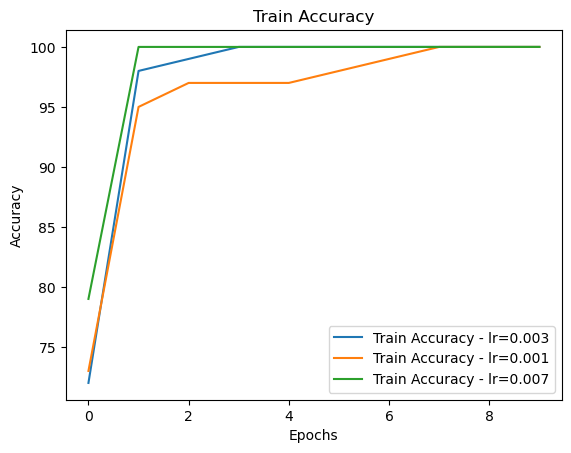

[0.003, 0.001, 0.007] [97.61904761904762, 97.61904761904762, 97.61904761904762]


In [97]:
# plot
import matplotlib.pyplot as plt
plt.figure()
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
for lr, result in results.items():
    plt.plot(result['train_acc'], label=f"Train Accuracy - lr={lr}")
plt.legend()
plt.show()

print([float(lr) for lr in results.keys()], [result['val_acc'][-1] for result in results.values()])
# plt.figure()
# plt.title("Validation Accuracy")
# plt.xlabel("Learning Rate")
# plt.ylabel("Accuracy")
# plt.plot([float(lr) for lr in results.keys()], [result['val_acc'][-1] for result in results.values()])


## Save the model

In [103]:
torch.save(model.state_dict(), 'dinov2_classifier.pth')

## Prediction test dataset

In [ ]:
# Load model

model.load_state_dict(torch.load("dinov2_classifier.pth"))
model.eval()


/var/folders/q0/_kslfxpx2254x8gnh887x3zc0000gn/T/ipykernel_2733/2869583502.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("dinov2_class

Predicted Class: dandelion


In [112]:

# Predict on a single image
from PIL import Image
for i in range(90, 100):
    image = Image.open(f"/Users/phuongnguyen/Documents/cours_BGD_Telecom_Paris_2024/712_MLOps/dataset_project/test/grass/000000{i}.jpg")
    image = transform(image).unsqueeze(0).to(device)

    output = model(image)
    predicted_class = output.argmax(dim=1).item()

    class_names = ["dandelion", "grass"]
    print(f"Predicted Class: {class_names[predicted_class]}")

Predicted Class: grass
Predicted Class: grass
Predicted Class: grass
Predicted Class: grass
Predicted Class: grass
Predicted Class: grass
Predicted Class: grass
Predicted Class: grass
Predicted Class: grass
Predicted Class: grass


In [ ]:
import boto3
from boto3.session import Session

s3 = boto3.client(
    's3',
    aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY')
)
# for train data
for i in range(0,50):
    if i < 10:
        s3.download_file('image-dadelion-grass', 'dandelion/0000000'+str(i)+'.jpg', '/Users/phuongnguyen/Documents/cours_BGD_Telecom_Paris_2024/712_MLOps/dataset_project/train/dandelion/0000000'+str(i)+'.jpg')
    else:
        s3.download_file('image-dadelion-grass', 'dandelion/000000'+str(i)+'.jpg', '/Users/phuongnguyen/Documents/cours_BGD_Telecom_Paris_2024/712_MLOps/dataset_project/train/dandelion/000000'+str(i)+'.jpg')
# s3.download_file('image-dadelion-grass', 'dandelion/00000047.jpg', '/Users/phuongnguyen/Documents/cours_BGD_Telecom_Paris_2024/712_MLOps/dataset_project/train/00000047.jpg')
